***Target Trial Emulation in R***

**by Alan Yang**

**Re-Written by: Laurenz Mesiah A. Palanas & Emily Rose Escartin**

This tutorial outlines the steps for implementing a Target Trial Emulation in R using the TrialEmulation package.

The process begins by defining the estimand, such as **intention-to-treat (ITT)** or **per-protocol (PP)**, and preparing observational data with specified columns for treatment, outcomes, and eligibility.

Censoring mechanisms, including **treatment switching** and **informative censoring**, are addressed using inverse probability of censoring weights (IPCW). Separate models are fitted to calculate these weights and adjust for biases.

The workflow proceeds to **expand the observational dataset** into a sequence of trials using pre-defined expansion options, creating trial-specific datasets. These datasets are then loaded and sampled for analysis.

A **marginal structural model (MSM)** is fit to estimate the causal effects. Predictions, such as survival probabilities and cumulative incidences, are generated for different treatment scenarios. The results are visualized to show survival differences over time, enabling meaningful inference on the treatment effects.

***1. Setup***

First check if the version of R is updated

In [13]:
R.version.string

[1] "R version 4.4.3 (2025-02-28 ucrt)"

then, install the packages of TrialEmulation

In [10]:
install.packages("TrialEmulation")

Installing package into 'C:/Users/laure/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'TrialEmulation' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\laure\AppData\Local\Temp\RtmpEtvYlD\downloaded_packages


After installation, load the package:

In [12]:
library(TrialEmulation)

A sequence of target trials analysis starts by specifying which estimand will be used:

In [15]:
trial_pp  <- trial_sequence(estimand = "PP")  # Per-protocol

trial_itt <- trial_sequence(estimand = "ITT") # Intention-to-treat

Additionally it is useful to create a directory to save files for later inspection.

In [ ]:
trial_pp_dir  <- file.path(tempdir(), "trial_pp")
dir.create(trial_pp_dir)

trial_itt_dir <- file.path(tempdir(), "trial_itt")
dir.create(trial_itt_dir)

***2. Data preparation***

Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

In [16]:
data("data_censored") # dummy data in the package
head(data_censored)

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,1,0,1,1,1.146148362,0,0.734203,36,0.08333333,0,0,1
2,1,1,1,1,0.002200337,0,0.734203,37,0.16666667,0,0,0
3,1,2,1,0,-0.481762418,0,0.734203,38,0.25000000,0,0,0
4,1,3,1,0,0.007872396,0,0.734203,39,0.33333333,0,0,0
5,1,4,1,1,0.216053715,0,0.734203,40,0.41666667,0,0,0
6,1,5,1,0,-0.057481504,0,0.734203,41,0.50000000,0,1,0


In [17]:
# Per-protocol
trial_pp <- trial_pp |>
  set_data(
    data      = data_censored,
    id        = "id",
    period    = "period",
    treatment = "treatment",
    outcome   = "outcome",
    eligible  = "eligible"
  )

# ITT
# Function style without pipes
trial_itt <- set_data( 
  trial_itt,
  data      = data_censored,
  id        = "id",
  period    = "period",
  treatment = "treatment",
  outcome   = "outcome",
  eligible  = "eligible"
)

In [18]:
trial_itt

Trial Sequence Object 
Estimand: Intention-to-treat 
 
Data: 
 - N: 725 observations from 89 patients 
        id period treatment    x1           x2    x3        x4   age      age_s
     <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>
  1:     1      0         1     1  1.146148362     0 0.7342030    36 0.08333333
  2:     1      1         1     1  0.002200337     0 0.7342030    37 0.16666667
 ---                                                                           
724:    99      6         1     1 -0.033762356     1 0.5752681    71 3.00000000
725:    99      7         0     0 -1.340496520     1 0.5752681    72 3.08333333
     outcome censored eligible time_on_regime
       <num>    <int>    <num>          <num>
  1:       0        0        1              0
  2:       0        0        0              1
 ---                                         
724:       0        0        0              1
725:       1        0        0              2
 
IPW for infor

***3. Weight models and censoring***

To adjust for the effects of informative censoring, inverse probability of censoring weights (IPCW) can be applied. To estimate these weights, we construct time-to-(censoring) event models. Two sets of models are fit for the two censoring mechanisms which may apply: censoring due to deviation from assigned treatment and other informative censoring.

***3.1 Censoring due to treatment switching***

We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.

In [19]:
trial_pp <- trial_pp |>
  set_switch_weight_model(
    numerator    = ~ age,
    denominator  = ~ age + x1 + x3,
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "switch_models"))
  )
trial_pp@switch_weights

ERROR: Error: object 'trial_pp_dir' not found


***3.2 Other informative censoring***

In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specifycensor_event which is the column containing the censoring indicator.

In [20]:
trial_pp <- trial_pp |>
  set_censor_weight_model(
    censor_event = "censored",
    numerator    = ~ x2,
    denominator  = ~ x2 + x1,
    pool_models  = "none",
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "switch_models"))
  )
trial_pp@censor_weights

ERROR: Error: object 'trial_pp_dir' not found


In [21]:
trial_itt <- set_censor_weight_model(
  trial_itt,
  censor_event = "censored",
  numerator    = ~x2,
  denominator  = ~ x2 + x1,
  pool_models  = "numerator",
  model_fitter = stats_glm_logit(save_path = file.path(trial_itt_dir, "switch_models"))
)
trial_itt@censor_weights

ERROR: Error: object 'trial_itt_dir' not found


***4. Calculate Weights***

Next we need to fit the individual models and combine them into weights. This is done with calculate_weights().

In [43]:
trial_pp_dir  <- file.path(tempdir(), "trial_pp") # Define a save directory
dir.create(trial_pp_dir, showWarnings = FALSE)    # Create the directory if it doesn't exist

trial_pp <- trial_pp |> set_switch_weight_model(
    numerator    = ~ age,         
    denominator  = ~ age + x1 + x3, 
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "switch_models")) 
)

trial_itt <- set_censor_weight_model(
    trial_itt,
    censor_event = "censored",
    numerator    = ~ x2,
    denominator  = ~ x2 + x1,
    pool_models  = "numerator",
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "censor_models"))
)

trial_pp <- trial_pp |> set_censor_weight_model(
    censor_event = "censored",
    numerator    = ~ x2,         # Variables in numerator model
    denominator  = ~ x2 + x1,    # Variables in denominator model
    pool_models  = "none",       # No pooling
    model_fitter = stats_glm_logit(save_path = file.path(trial_pp_dir, "censor_models"))
)





trial_pp  <- trial_pp |> calculate_weights()
trial_itt <- calculate_weights(trial_itt)


The full model objects are saved to disk in the directories we created above. The summaries are stored in the trial sequence object and can be printed:

In [44]:
show_weight_models(trial_itt)

Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator 
 
 term        estimate   std.error statistic p.value     
 (Intercept)  2.4480907 0.1405726 17.415128 6.334656e-68
 x2          -0.4486482 0.1368765 -3.277759 1.046346e-03
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 404.2156      724     -196.7002 397.4004 406.5727 393.4004 723         725 
 
 path                                                                                            
 C:\\Users\\laure\\AppData\\Local\\Temp\\RtmpEtvYlD/trial_pp/censor_models\\model_4f8cba3674b.rds
 
[[d0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator 
 
 term        estimate   std.error statistic p.value     
 (Intercept)  1.8941961 0.2071122  9.145746 5.921948e-20
 x2          -0.5898292 0.1693402 -3.483101 4.956409e-04
 x1           0.8552603 0.3452930  2.476912 1.325247e-02
 
 null.deviance df.null logL

In [45]:
show_weight_models(trial_pp)

Weight Models for Informative Censoring
---------------------------------------

[[n0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for numerator 
 
 term        estimate   std.error statistic p.value     
 (Intercept)  1.4026538 0.1993673  7.035525 1.985118e-12
 x2          -0.5436594 0.2075654 -2.619220 8.813109e-03
 
 null.deviance df.null logLik    AIC     BIC      deviance df.residual nobs
 172.8729      169     -82.81349 169.627 175.8986 165.627  168         170 
 
 path                                                                                            
 C:\\Users\\laure\\AppData\\Local\\Temp\\RtmpEtvYlD/trial_pp/censor_models\\model_4f8c237d2f9.rds
 
[[n1]]
Model: P(censor_event = 0 | X, previous treatment = 1) for numerator 
 
 term        estimate   std.error statistic  p.value     
 (Intercept)  2.7365126 0.3465786  7.8957919 2.884776e-15
 x2          -0.1259467 0.3527451 -0.3570472 7.210564e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance 

***5. Specify Outcome Model***

Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.

In [46]:
trial_pp  <- set_outcome_model(trial_pp)
trial_itt <- set_outcome_model(trial_itt, adjustment_terms = ~x2)

***6. Expand Trials***

Now we are ready to create the data set with all of the sequence of target trials.

In [47]:
trial_pp <- set_expansion_options(
  trial_pp,
  output     = save_to_datatable(),
  chunk_size = 500 # the number of patients to include in each expansion iteration
)
trial_itt <- set_expansion_options(
  trial_itt,
  output     = save_to_datatable(),
  chunk_size = 500
)

***6.1 Create Sequence of Trials Data***

In [48]:
trial_pp  <- expand_trials(trial_pp)
trial_itt <- expand_trials(trial_itt)

In [49]:
trial_pp@expansion

Sequence of Trials Data: 
- Chunk size: 500 
- Censor at switch: TRUE 
- First period: 0 | Last period: Inf 
 
A TE Datastore Datatable object 
N: 500 observations 
        id trial_period followup_time outcome    weight treatment         x2
     <int>        <int>         <int>   <num>     <num>     <num>      <num>
  1:     1            0             0       0 1.0000000         1  1.1461484
  2:     1            0             1       0 0.8951447         1  1.1461484
 ---                                                                        
499:    99            0             0       0 1.0000000         1 -0.3463778
500:    99            0             1       0 1.0122336         1 -0.3463778
       age assigned_treatment
     <num>              <num>
  1:    36                  1
  2:    36                  1
 ---                         
499:    65                  1
500:    65                  1

***7. Load or Sample from Expanded Data***

Now that the expanded data has been created, we can prepare the data to fit the outcome model. For data that can fit comfortably in memory, this is a trivial step using load_expanded_data.

For large datasets, it may be necessary to sample from the expanded by setting the p_control argument. This sets the probability that an observation with outcome == 0 will be included in the loaded data. A seed can be set for reproducibility. Additionally, a vector of periods to include can be specified, e.g., period = 1:60, and/or a subsetting condition, subset_condition = "age > 65".

In [50]:
trial_itt <- load_expanded_data(trial_itt, seed = 1234, p_control = 0.5)

***8. Fit Marginal Structural Model***

To fit the outcome model we use fit_msm().

In [51]:
trial_itt <- fit_msm(
  trial_itt,
  weight_cols    = c("weight", "sample_weight"),
  modify_weights = function(w) { # winsorization of extreme weights
    q99 <- quantile(w, probs = 0.99)
    pmin(w, q99)
  }
)

Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Model summary:

In [52]:
trial_itt@outcome_model

- Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2) 
- Treatment variable: assigned_treatment 
- Adjustment variables: x2 
- Model fitter type: te_stats_glm_logit 
 
Model Summary: 
 
 term               estimate std.error statistic p.value conf.low conf.high
 (Intercept)        -6.02    0.780      -7.72    1.2e-14 -7.550   -4.4916  
 assigned_treatment  1.63    0.496       3.28    1.0e-03  0.654    2.5977  
 x2                  0.31    0.418       0.74    4.6e-01 -0.511    1.1282  
 followup_time       0.34    0.244       1.38    1.7e-01 -0.141    0.8148  
 I(followup_time^2) -0.02    0.014      -1.42    1.5e-01 -0.049    0.0077  
 trial_period        7.29    0.978       7.45    9.1e-14  5.371    9.2040  
 I(trial_period^2)  -7.68    0.537     -14.31    1.8e-46 -8.737   -6.6325  
 
 null.deviance df.null logLik AIC BIC deviance df.residual nobs
 158           800     -69.1  152 185 135      794         801 

Depending on the model fitter used, we can also access the model object. For the default stats::glm logistic model, we have the glm object as well as the sandwich variance-covariance matrix.

In [53]:
trial_itt@outcome_model@fitted@model$model


Call:  glm(formula = formula, family = binomial("logit"), data = data, 
    weights = weights, x = FALSE, y = FALSE)

Coefficients:
       (Intercept)  assigned_treatment                  x2       followup_time  
          -6.02067             1.62585             0.30837             0.33673  
I(followup_time^2)        trial_period   I(trial_period^2)  
          -0.02049             7.28762            -7.68478  

Degrees of Freedom: 800 Total (i.e. Null);  794 Residual
Null Deviance:	    157.8 
Residual Deviance: 134.7 	AIC: 152.2

In [54]:
trial_itt@outcome_model@fitted@model$vcov

,(Intercept),assigned_treatment,x2,followup_time,I(followup_time^2),trial_period,I(trial_period^2)
(Intercept),0.608651263,-0.007606479,0.042942422,-0.143451214,0.0071306658,-0.10588545,0.04905589
assigned_treatment,-0.007606479,0.245882729,0.087953406,-0.052364376,0.0028157357,-0.34160925,0.16500968
x2,0.042942422,0.087953406,0.174977954,-0.045052691,0.0028438066,-0.09744074,0.04621905
followup_time,-0.143451214,-0.052364376,-0.045052691,0.059487800,-0.0033621580,0.10445403,-0.05496908
I(followup_time^2),0.007130666,0.002815736,0.002843807,-0.003362158,0.0002067028,-0.00514379,0.00265172
trial_period,-0.105885453,-0.341609248,-0.097440741,0.104454026,-0.0051437905,0.95604134,-0.51334414
I(trial_period^2),0.049055893,0.165009684,0.046219048,-0.054969078,0.0026517200,-0.51328532,0.28822666


The complete object shows all the specifications:

In [55]:
trial_itt

Trial Sequence Object 
Estimand: Intention-to-treat 
 
Data: 
 - N: 725 observations from 89 patients 
        id period treatment    x1           x2    x3        x4   age      age_s
     <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>
  1:     1      0         1     1  1.146148362     0 0.7342030    36 0.08333333
  2:     1      1         1     1  0.002200337     0 0.7342030    37 0.16666667
 ---                                                                           
724:    99      6         1     1 -0.033762356     1 0.5752681    71 3.00000000
725:    99      7         0     0 -1.340496520     1 0.5752681    72 3.08333333
     outcome censored eligible time_on_regime        wt       wtC
       <num>    <int>    <num>          <num>     <num>     <num>
  1:       0        0        1              0 0.9835463 0.9835463
  2:       0        0        0              1 0.9429254 0.9429254
 ---                                                             
724:   

***9. Inference***

We use the predict() method to estimate survival probabilities or cumulative incidences for different values of assigned_treatment.

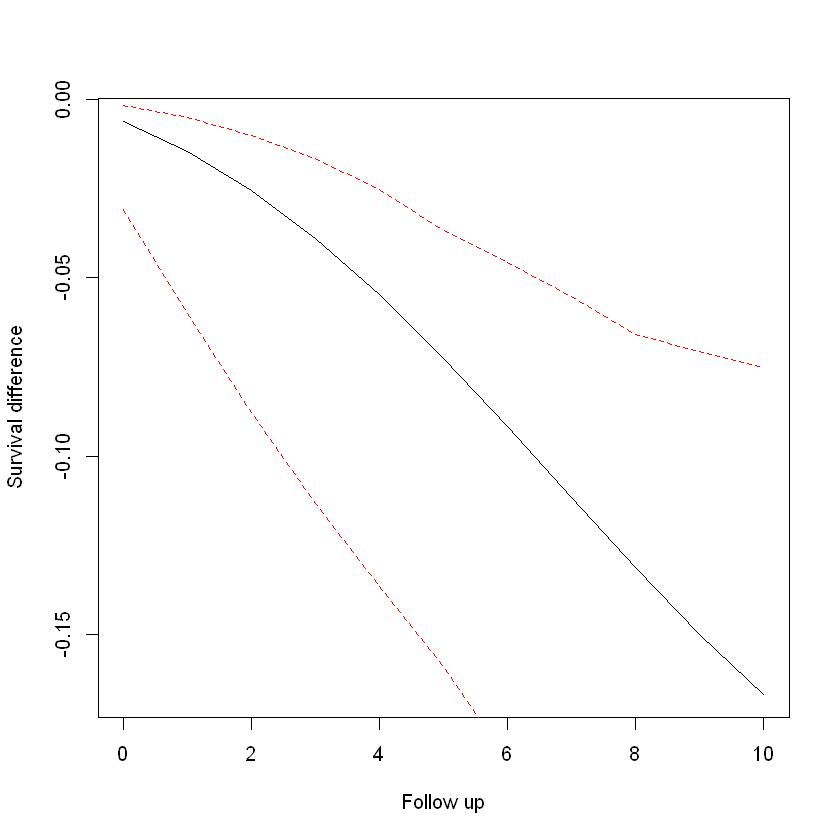

In [56]:
preds <- predict(
  trial_itt,
  newdata       = outcome_data(trial_itt)[trial_period == 1, ],
  predict_times = 0:10,
  type          = "survival",
)

plot(preds$difference$followup_time, preds$difference$survival_diff,
  type = "l", xlab = "Follow up", ylab = "Survival difference")
lines(preds$difference$followup_time, preds$difference$`2.5%`, type = "l", col = "red", lty = 2)
lines(preds$difference$followup_time, preds$difference$`97.5%`, type = "l", col = "red", lty = 2)